d:\PALPU\project_qpa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PALPU\project_qpa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\PALPU\project_qpa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 41.0}, '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 61.0}, '2.0': {'precision': 0.43333333333333335, 'recall': 1.0, 'f1-score': 0.6046511627906976, 'support': 78.0}, 'accuracy': 0.43333333333333335, 'macro avg': {'precision': 0.14444444444444446, 'recall': 0.3333333333333333, 'f1-score': 0.20155038759689922, 'support': 180.0}, 'weighted avg': {'precision': 0.1877777777777778, 'recall': 0.43333333333333335, 'f1-score': 0.262015503875969, 'support': 180.0}}
{
    "0.0": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 41.0
    },
    "1.0": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 61.0
    },
    "2.0": {
        "precision": 0.43333333333333335,
        "recall": 1.0,
        "f1-score": 0.6046511627906976,
        "support": 78.0
    },
    "accuracy": 0.43333333333333335,
    "macro avg": {
   

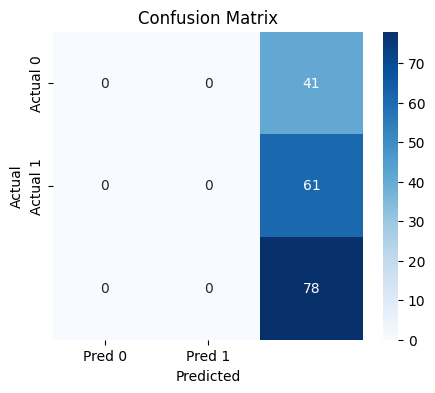

In [1]:
import json
import pandas as pd
import numpy as np
import csv
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Step 1: Decision Tree Class
class DecisionTree:
    def __init__(self, max_depth, min_size):
        self.max_depth = max_depth
        self.min_size = min_size
        self.tree = None

    # Step 2: Load the dataset from CSV
    def load_data(self, filepath):
        data = pd.read_csv(filepath)
        dataset = data.values.tolist()  # Convert to list of lists
        return dataset

    # Step 3: Gini Impurity calculation
    def gini_impurity(self, groups, classes):
        n_instances = sum([len(group) for group in groups])  # Total instances
        gini = 0.0
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                proportion = (group.count(class_val) / size)
                score += proportion ** 2
            gini += (1.0 - score) * (size / n_instances)
        return gini

    # Step 4: Split the dataset
    def test_split(self, index, value, dataset):
        left, right = [], []
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right

    # Step 5: Find the best split
    def get_split(self, dataset):
        class_values = list(set(row[-1] for row in dataset))
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        for index in range(len(dataset[0]) - 1):  # Exclude target column
            # if index == 0:  # Skip the 'questiontype' feature (assuming it's the first feature)
            #     continue
            for row in dataset:
                groups = self.test_split(index, row[index], dataset)
                gini = self.gini_impurity(groups, class_values)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], gini, groups
        return {'index': b_index, 'value': b_value, 'groups': b_groups}

    # Step 6: Create terminal node (leaf node)
    def to_terminal(self, group):
        outcomes = [row[-1] for row in group]
        return max(set(outcomes), key=outcomes.count)

    # Step 7: Split a node recursively
    def split(self, node, depth):
        left, right = node['groups']
        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.to_terminal(left + right)
            return
        if depth >= self.max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        if len(left) <= self.min_size:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            self.split(node['left'], depth + 1)

        if len(right) <= self.min_size:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            self.split(node['right'], depth + 1)

    # Step 8: Build the decision tree
    def build_tree(self, train):
        root = self.get_split(train)
        self.split(root, 1)
        return root

    # Step 9: Make prediction
    def predict(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict(node['right'], row)
            else:
                return node['right']

    # Step 10: Predict for all rows in the test dataset
    def predict_all(self, tree, test):
        predictions = []
        for row in test:
            prediction = self.predict(tree, row)
            predictions.append(prediction)
        return predictions

    # Step 11: Accuracy Metric
    def accuracy(self, actual, predicted):
        correct = sum([1 if actual[i] == predicted[i] else 0 for i in range(len(actual))])
        return correct / len(actual) * 100.0

    # Step 12: Split dataset into training and testing
    def train_test_split(self, dataset, split_ratio=0.85):
        train_size = int(len(dataset) * split_ratio)
        train_set = dataset[:train_size]
        test_set = dataset[train_size:]
        return train_set, test_set

    # Step 13: Train and evaluate the model
    def train_and_evaluate(self, filepath):
        dataset = self.load_data(filepath)

        # Split into train and test datasets
        train, test = self.train_test_split(dataset)

        # Build the decision tree
        self.tree = self.build_tree(train)

        # Evaluate the model
        actual = [row[-1] for row in test]
        predicted = self.predict_all(self.tree, test)
        
        report = classification_report(actual, predicted, output_dict=True)
        print(report)
        
        #JSON format requires a structured dictionary or list of key-value pairs, not a string.
        with open('classification_report.json', 'w') as json_file:
            json.dump(report, json_file, indent=4)

        # Print the classification report
        print(json.dumps(report, indent=4))
        accuracy = self.accuracy(actual, predicted)
        print(f"Accuracy: {accuracy:.2f}%")

        # Compute confusion matrix
        cm = confusion_matrix(actual, predicted).tolist()  # Convert to list for JSON storage

        # Save confusion matrix to JSON file
        with open("confusion_matrix.json", "w") as f:
            json.dump(cm, f)

        # Plot and save confusion matrix image
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")

        plt.savefig("static/confusion_matrix.png")
        plt.show()
        
        return self.tree

# Main Execution
if __name__ == "__main__":
    # Initialize the decision tree model
    max_depth = 5
    min_size = 2
    model = DecisionTree(max_depth=max_depth, min_size=min_size)

    # Train and evaluate the model
    tree = model.train_and_evaluate("dataset final/training_dataset.csv")
    #tree = model.train_and_evaluate("training_data/training_dataset.csv")

In [57]:
import json
print(json.dumps(model.tree, indent=4))

{
    "index": 0,
    "value": 0.0,
    "left": 2.0,
    "right": 2.0
}


In [58]:
from pprint import pprint
pprint(tree)  # Display the full tree structure

{'index': 0, 'left': 2.0, 'right': 2.0, 'value': 0.0}


In [59]:
import pickle

# Save the trained decision tree
with open('custom_decision_tree_model.pkl', 'wb') as file:
    pickle.dump(tree, file)

print("Model saved successfully!")


Model saved successfully!


In [27]:
import pickle

# Load the model from the pickle file
with open('files/custom_decision_tree_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# 1. Check the type of the model
print("Model type:", type(model))

# 2. Check if it's a dictionary (since you are saving a custom decision tree in dictionary format)
if isinstance(model, dict):
    print("The model is a dictionary (tree structure).")
else:
    print("The model is not a dictionary. Something might be wrong.")

# 3. Check the model's structure by printing the root node
print("\nModel structure (root node):")
print(model)




Model type: <class 'dict'>
The model is a dictionary (tree structure).

Model structure (root node):
{'index': 1, 'value': 0.0, 'left': 0.0, 'right': 0.0}


In [42]:
import pandas as pd
import numpy as np
import string
import nltk
import re
import pickle
from sklearn.preprocessing import OneHotEncoder
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from rake_nltk import Rake
import sqlite3

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# SQLite database connection
conn = sqlite3.connect('questions.db')
cursor = conn.cursor()

# Helper functions (same as before)
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in string.punctuation and word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    stemmed = [stemmer.stem(word) for word in lemmatized]
    return stemmed

def extract_qtype(question):
    rake.extract_keywords_from_text(question)
    keywords = rake.get_ranked_phrases()
    computational_keywords = {"perform", "generate", "database", "create", "design", "implement", "calculate", "determine", "solve", "compute", "evaluate", "simplify"}
    descriptive_keywords = {"justify", "method", "process", "procedure", "solution", "explain", "describe", "illustrate", "state", "discuss", "write", "why"}
    proof_keywords = {"prove", "verify", "demonstrate", "show"}
    statistical_keywords = {"test", "hypothesis", "mean", "variance", "confidence", "significance"}
    what_keywords = {"what", "define", "list"}
    differentiate_keywords = {"differentiate", "contrast", "compare"}
    mathematical_keywords = {"solve", "convert", "find", "equation", "function", "integral", "derivative", "matrix"}
    discrete_keywords = {"graph", "logic", "combinatorics", "relation", "algorithm"}
    
    scores = {"Computational": 0, "Descriptive": 0, "Proof": 0, "Statistical": 0, "What": 0, "Differentiate": 0, "Mathematical": 0, "Discrete": 0, "Other": 0}

    for phrase in keywords:
        words = phrase.split()
        for word in words:
            if word in computational_keywords:
                scores["Computational"] += 1
            elif word in descriptive_keywords:
                scores["Descriptive"] += 1
            elif word in proof_keywords:
                scores["Proof"] += 1
            elif word in statistical_keywords:
                scores["Statistical"] += 1
            elif word in what_keywords:
                scores["What"] += 1
            elif word in differentiate_keywords:
                scores["Differentiate"] += 1
            elif word in mathematical_keywords:
                scores["Mathematical"] += 1
            elif word in discrete_keywords:
                scores["Discrete"] += 1

    max_score_type = max(scores, key=scores.get)
    return "Other" if scores[max_score_type] == 0 else max_score_type

def keyword_count(question):
    rake.extract_keywords_from_text(question)
    keywords = rake.get_ranked_phrases()
    return len(keywords)

def compute_tf_idf(questions):
    tf = []
    idf = {}
    N = len(questions)
    vocabulary = set()
    processed_questions = [preprocess_text(q) for q in questions]
    for q in processed_questions:
        freq = {}
        for word in q:
            vocabulary.add(word)
            freq[word] = freq.get(word, 0) + 1
        tf.append(freq)

    for word in vocabulary:
        count = sum(1 for q in processed_questions if word in q)
        idf[word] = np.log(N / (1 + count))

    tf_idf_scores = []
    for q_tf in tf:
        scores = {word: tf_val * idf[word] for word, tf_val in q_tf.items()}
        tf_idf_scores.append(scores)
    return tf_idf_scores

def avg_word_length(text):
    question_tokens = preprocess_text(text)
    total_length = sum(len(word) for word in question_tokens)
    return 0 if not question_tokens else total_length / len(question_tokens)

def sentence_count(question):
    return len(re.split(r'[.!?]', question)) - 1

def readability_score(question):
    sentences = sent_tokenize(question)
    words = word_tokenize(question)
    complex_words = [word for word in words if len(word) > 2 and word not in string.punctuation]
    word_count = len(words)
    sentence_count = len(sentences)
    complex_word_count = len(complex_words)
    
    if sentence_count == 0 or word_count == 0:
        return 0
    gunning_fog = 0.4 * ((word_count / sentence_count) + 100 * (complex_word_count / word_count))
    return gunning_fog

# Initialize lemmatizer, stemmer, and stop words
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# RAKE initialization
rake = Rake(stopwords=stop_words)

# Retrieve data from SQLite database
cursor.execute("SELECT question FROM questionlist")
questions = [row[0] for row in cursor.fetchall()]

# Extract features for each question and store them in a list
features_data = []

for question in questions:
    features = []
    features.append(extract_qtype(question))  # qtype
    features.append(keyword_count(question))  # keyword count
    tf_idf_scores = compute_tf_idf([question])
    features.append(np.mean(list(tf_idf_scores[0].values())) if tf_idf_scores[0] else 0)  # TF-IDF score
    features.append(sentence_count(question))  # sentence count
    features.append(readability_score(question))  # readability score
    features.append(avg_word_length(question))  # average word length
    features_data.append(features)

# Convert the feature list into a DataFrame
features_df = pd.DataFrame(features_data, columns=["qtype", "keyword_count", "keyword_tfidf", "sentence_count", "readability_scores", "avg_word_length"])

# One-hot encoding for qtype
encoder = OneHotEncoder(sparse_output=False)
qtype_encoded = encoder.fit_transform(features_df[["qtype"]])
qtype_encoded_df = pd.DataFrame(qtype_encoded, columns=encoder.get_feature_names_out(["qtype"]))
features_df = pd.concat([features_df.reset_index(drop=True), qtype_encoded_df.reset_index(drop=True)], axis=1)

# Select numeric features only
features_df_numeric = features_df.select_dtypes(include=['float64', 'int64'])

# Fill missing values in the numeric feature columns using the mean
features_df_numeric = features_df_numeric.fillna(features_df_numeric.mean())

# Load the pre-trained custom decision tree model from the .pkl file
with open('files/custom_decision_tree_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

# Function to predict using the custom decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Make predictions using the pre-trained custom decision tree model
predictions = [predict(model, row) for row in features_df_numeric.values]

# Print the predictions
print(predictions)

# Close the database connection
conn.close()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


OperationalError: no such table: questionlist

In [32]:
print(model)

{'index': 1, 'value': 1.0, 'left': {'index': 1, 'value': 0.0, 'left': 1.0, 'right': 1.0}, 'right': {'index': 1, 'value': 1.0, 'left': 1.0, 'right': 1.0}}
